# KAZ env  

In [1]:
from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt

import time 

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
import tensorflow as tf
import datetime



## 1 DQN pour tous

In [3]:
# env KAZ
aec_env = knights_archers_zombies_v10.env()

# conversion en parallele
parallel_env = aec_to_parallel(aec_env)

# wrapper 'black_death_v3' pour les agents morts/inactifs
parallel_env = ss.black_death_v3(parallel_env)

# SuperSuit pour environnement Gym et stablebaselines 3
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')


# Hyperparams
epsilon = 0.8
epsilon_decay = 0.98
epsilon_min = 0.05
gamma = 0.999
lr = 0.0001
batch_size = 64
buffer_capacity = 1024
target_update_freq = 1000
num_episodes = 1_000_000 # Tres grand pour un arret via le nombre de pas  TODO
reward_penalty = 1

# init DQN
model = DQN('MlpPolicy', 
            gym_env, 
            verbose=1,
            tensorboard_log="./logs/",
            learning_rate=lr,
            buffer_size=buffer_capacity,
            learning_starts=buffer_capacity,
            batch_size=batch_size,
            target_update_interval=target_update_freq,
            gamma=gamma,
            exploration_fraction=epsilon,
            exploration_final_eps=epsilon_min,
            exploration_initial_eps=epsilon,
            )

model.learn(total_timesteps=250_000, tb_log_name="dqn_knights_archers_zombies_SoloDQN")

# save modele
model.save("dqn_knights_archers_zombies")

# Charger le modele pour evaluer
model = DQN.load("dqn_knights_archers_zombies")

# eval le modèle
env = knights_archers_zombies_v10.parallel_env()
env = ss.black_death_v3(env)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
model.set_env(env)

obs = env.reset()
rewards = []
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done.any():
        obs = env.reset()

# Affiche les récompenses
plt.plot(np.cumsum(rewards))
plt.show()

# # Make a video of the trained model
# env = knights_archers_zombies_v10.parallel_env()
# env = ss.black_death_v3(env)
# env = ss.pettingzoo_env_to_vec_env_v1(env)
# env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
# model.set_env(env)
# ss.record_video(env, model, "dqn_knights_archers_zombies.mp4", video_length=1000, fps=10)

# # Afficher la vidéo


Using cpu device
Logging to ./logs/dqn_knights_archers_zombies_SoloDQN_2
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1249     |
|    time_elapsed     | 0        |
|    total_timesteps  | 736      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.795    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1171     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1392     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00611  |
|    n_updates        | 22       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes    

KeyboardInterrupt: 

## 4 DQN indep

In [ ]:

# charge env
aec_env = knights_archers_zombies_v10.env()

# Convertir en parallele
parallel_env = aec_to_parallel(aec_env)

parallel_env = ss.black_death_v3(parallel_env)

# SuperSuit pour convertir en un Gym compatible
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')

# Initialiser les modèles DQN pour chaque agent
num_agents = gym_env.num_envs  # Récupérer le nombre d'agents à partir de l'environnement
models_archer = [DQN(  
                'MlpPolicy', 
                gym_env, 
                verbose=0,
                learning_rate=0.001,
                buffer_size=10000,
                batch_size=64,
                learning_starts=200,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=100,
                exploration_fraction=0.3,
                exploration_initial_eps=0.05,
                exploration_final_eps=0.03,
                gamma=0.96

            ) for _ in range(2)]

models_knight = [DQN(  
                'MlpPolicy', 
                gym_env, 
                verbose=0,
                learning_rate=0.001,
                buffer_size=10000,
                batch_size=64,
                learning_starts=200,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=100,
                exploration_fraction=0.3,
                exploration_initial_eps=0.05,
                exploration_final_eps=0.03,
                gamma=0.96
            ) for _ in range(2)]

models = models_archer + models_knight

start_t = time.time()

# Entraîner les agents
timesteps = 10_000
nb_episodes = 20
for episode in range(nb_episodes):  # Nombre d'épisodes d'entraînement
    t = time.time() - start_t
    hours, remainder = divmod(t, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Episode {episode + 1} - Temps écoulé: {int(hours):02}:{int(minutes):02}:{int(seconds):02} s")
    obs = gym_env.reset()
    done = np.array([False] * num_agents)

    for step in range(timesteps):
        if step % 1000 == 0:
            print(f"Step {step}/{timesteps}")
        actions = np.array([models[i].predict(obs[i])[0] for i in range(num_agents)])  # Prédire les actions pour chaque agent
        obs, rewards_batch, done, _ = gym_env.step(actions)  # Appliquer les actions dans l'environnement
        
        for i in range(num_agents):
            models[i].learn(total_timesteps=1)  # Mettre à jour chaque agent après chaque étape
        
        if done.all():
            obs = gym_env.reset()
            done = np.array([False] * num_agents)

    for i in range(num_agents):
        models[i].learn(total_timesteps=100)

    # Sauvegarder les modèles
    for i in range(num_agents):
        models[i].save(f"./checkpoints/dqn_agent_{i + 1}_knights_archers_zombies_{episode}")

# Sauvegarder les modèles
for i in range(num_agents):
    models[i].save(f"dqn_agent_{i + 1}_knights_archers_zombies")

print("Entraînement terminé !")

Episode 1 - Temps écoulé: 00:00:00 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000


/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'checkpoints' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Episode 2 - Temps écoulé: 00:02:18 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 3 - Temps écoulé: 00:04:38 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 4 - Temps écoulé: 00:06:57 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 5 - Temps écoulé: 00:09:17 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 6 - Temps écoulé: 00:11:37 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 7 - Temps écoulé: 00:1

## MADDQN

In [ ]:

# Config du réseau Q pour chaque agent
class QNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Adjust input_dim to match actual observation dimension
        self.fc2 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


# Fonction de selection d'action avec e-greedy
def select_action(state, q_net, epsilon, action_dim):
    if random.random() < epsilon:
        action = random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state.flatten())  
            q_values = q_net(state)
            action = torch.argmax(q_values).item()
    return action

# Buffer de replay pour stocker les expériences des agents
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [ ]:

# init de l'environnement et de chaque agent
env = knights_archers_zombies_v10.env(
  spawn_rate=20,
  num_archers=4,
  num_knights=0,
  max_zombies=10,
  max_arrows=8,
  killable_knights=True,
  killable_archers=True,
  max_cycles=900,)
env = aec_to_parallel(env)

env.reset()
agents = env.agents  # Obtenir la liste des agents apres reset
num_agents = len(agents)
state_dims = env.observation_space(agents[0]).shape[0] * 5
action_dims = env.action_space(agents[0]).n

# Hyperparams
epsilon = 0.8
epsilon_decay = 0.98
epsilon_min = 0.05
gamma = 0.999
lr = 0.0001
batch_size = 64
buffer_capacity = 1024
target_update_freq = 3
num_episodes = 1_000_000 # Tres grand pour un arret via le nombre de pas  TODO
reward_penalty = 1

# init des réseaux Q et des buffers pour chaque agent
q_networks =        {agent: QNetwork(state_dims, action_dims) for agent in agents}
target_networks =   {agent: QNetwork(state_dims, action_dims) for agent in agents}
optimizers =        {agent: optim.Adam(q_networks[agent].parameters(), lr=lr) for agent in agents}
buffers =           {agent: ReplayBuffer(buffer_capacity) for agent in agents}

# Gestion des agents inactifs / blackdeath a la main
black_obs = {agent: np.zeros_like(env.observation_space(agent).low) for agent in env.agents}
black_rewards = {agent: 0 for agent in env.agents}
black_dones = {agent: True for agent in env.agents}

# Nombre de pas maximum par épisode
max_steps = 500
nb_steps = 0
total_nb_steps = 0
max_total_steps = 250_000

# Logs
step_count = []
episode_rewards = []
agents_rewards = {agent: [] for agent in agents}
intra_episode_rewards = []
# Répertoire pour les logs de TensorBoard
log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_" + str(max_total_steps) +"steps"
writer = tf.summary.create_file_writer(log_dir)


# Synchronisation initiale des réseaux cibles
for agent in agents:
    target_networks[agent].load_state_dict(q_networks[agent].state_dict())

# Boucle d'entraînement
for episode in range(num_episodes):
   # obs,_ = env.reset()
   # state = {agent: env.observe(agent) for agent in agents}  # Initialiser l'état pour chaque agent
    state,_ = env.reset()
    done = {agent: False for agent in agents}
    episode_reward = {agent: 0 for agent in agents}

    # Init des rewards intrinseques par agent
    for agent in agents:
        agents_rewards[agent].append(0.0)
    intra_episode_rewards.append(0.0)

    while not (all(done.values()) or nb_steps >= max_steps):
        actions = {}
        
        # Sélection d'actions pour chaque agent
        for agent in agents:
            if not done[agent]:
                action = select_action(state[agent], q_networks[agent], epsilon, action_dims)
                
                # Vérification de l'action
                assert 0 <= action < action_dims, f"Action {action} pour {agent} n'est pas dans l'espace d'actions [0, {action_dims - 1}]"
                actions[agent] = action
                #print(f"Agent {agent} a choisi l'action {action}")

        # Environnement procède aux actions
        
        next_state, rewards, dones, _ ,_= env.step(actions)
        
        # Penalise le tire de fleche
        for agent in rewards:
            if actions[agent] == 4:
                rewards[agent] = -0.01


        dones = {**black_dones, **dones}
        rewards = {**black_rewards, **rewards}
        next_state = {**black_obs, **next_state}
        #print(rewards)

        # Reward intrinseque
        for agent in agents:
            agents_rewards[agent][-1] += rewards[agent]
            intra_episode_rewards[-1] += rewards[agent]

        # mean_global_reward = np.mean(list(rewards.values())) #TODO Maybe ?
        # rewards = {agent: rewards[agent]+mean_global_reward for agent in agents} 
        # Enregistrement de chaque expérience dans le buffer
        for agent in agents:
            if not done[agent]:
                if(dones[agent]):
                    rewards[agent]-= reward_penalty

                # rewards[agent] += mean_global_reward # Ajout de la récompense moyenne globale 
                
                buffers[agent].push(state[agent], actions[agent], rewards[agent], next_state[agent], dones[agent])
                episode_reward[agent] += rewards[agent]

            # Mise à jour des états et terminaux
            
            done[agent] = dones[agent]
        
        # Mise à jour des états pour le prochain pas de temps
        for agent in agents:
            if not done[agent]:
                state[agent] = next_state[agent]  # Mettre à jour l'état pour chaque agent

        # Apprentissage pour chaque agent
        for agent in agents:
            if len(buffers[agent]) >= batch_size: # and not done[agent]:

                # Extraction d'un mini-lot d'expériences
                batch = buffers[agent].sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Conversion des expériences en tenseurs
                states = torch.FloatTensor(np.array([s.flatten() for s in states])) #states = torch.FloatTensor([s.flatten() for s in states])
                next_states = torch.FloatTensor([ns.flatten() for ns in next_states])
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards)
                dones = torch.FloatTensor(dones)

                # Calcul des valeurs Q cibles
                with torch.no_grad():
                    target_values = rewards + gamma * torch.max(target_networks[agent](next_states), dim=1).values * (1 - dones)

                # Calcul des valeurs Q prédites
                q_values = q_networks[agent](states)
                q_values = q_values.gather(1, actions)

                # Calcul de la perte
                loss = nn.MSELoss()(q_values, target_values.unsqueeze(1))

                # Mise à jour du réseau
                optimizers[agent].zero_grad()
                loss.backward()
                optimizers[agent].step()
                

        # Mise à jour des réseaux cibles
        if episode % target_update_freq == 0:
            for agent in agents:
                target_networks[agent].load_state_dict(q_networks[agent].state_dict())

        nb_steps += 1
        total_nb_steps += 1



    nb_steps = 0
    # Décroissance de epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # print
    print(f"Steps {total_nb_steps}/{max_total_steps} ({round((total_nb_steps/max_total_steps)*100,3)}%) - Rewards: {tuple(episode_reward.values())}")
    
    # Logs
    episode_rewards.append(sum(episode_reward.values()))
    step_count.append(total_nb_steps)

    # for agent in agents:
    #     agents_rewards[agent].append(episode_reward[agent])

    with writer.as_default():
        for agent in agents:
            tf.summary.scalar(f"Agent_{agent}/Reward", agents_rewards[agent][-1], step=total_nb_steps)
        tf.summary.scalar("Global/Reward", intra_episode_rewards[-1], step=total_nb_steps)
        writer.flush()


    # Fin de l'entraînement
    if total_nb_steps >= max_total_steps:
        break


print("Entraînement terminé!")

# Sauvegarde des réseaux Q
for agent in agents:
    torch.save(q_networks[agent].state_dict(), f"q_network_agent_{agent}_knights_archers_zombies.pt")



Steps 243/250000 (0.097%) - Rewards: (0.7499999999999998, 1.5900000000000016, -1.27, -0.28000000000000014)
Steps 646/250000 (0.258%) - Rewards: (0.5899999999999999, -0.5800000000000003, 0.3999999999999997, 2.5600000000000067)
Steps 889/250000 (0.356%) - Rewards: (-1.4400000000000002, -1.4300000000000002, 0.6899999999999997, 0.7)
Steps 1092/250000 (0.437%) - Rewards: (-0.2300000000000001, -0.28000000000000025, -1.3, -1.5200000000000002)
Steps 1255/250000 (0.502%) - Rewards: (-1.3800000000000001, -0.2300000000000001, -1.33, -1.32)
Steps 1478/250000 (0.591%) - Rewards: (1.57, 0.6399999999999999, -1.2, 0.6799999999999997)
Steps 1701/250000 (0.68%) - Rewards: (0.5599999999999998, 0.6799999999999999, -1.37, -0.5900000000000004)
Steps 2024/250000 (0.81%) - Rewards: (1.4000000000000066, -0.4600000000000003, -1.37, 1.2300000000000066)
Steps 2207/250000 (0.883%) - Rewards: (0.78, -1.23, -1.2, 0.45999999999999974)
Steps 2510/250000 (1.004%) - Rewards: (3.2500000000000018, -0.5200000000000004, -1.

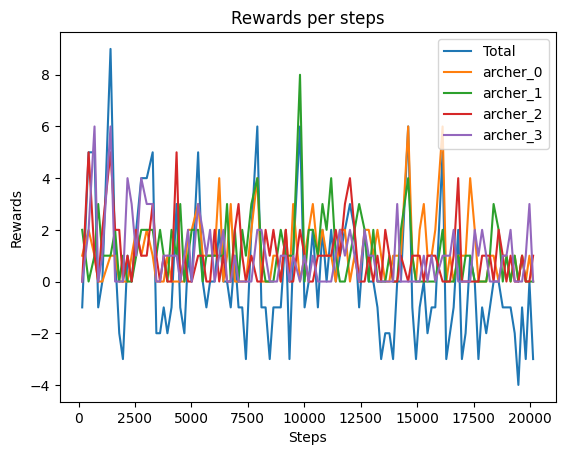

In [ ]:

# Affichage des récompenses
plt.plot(step_count, episode_rewards)
plt.plot(step_count, agents_rewards[agents[0]])
plt.plot(step_count, agents_rewards[agents[1]])
plt.plot(step_count, agents_rewards[agents[2]])
plt.plot(step_count, agents_rewards[agents[3]])
plt.legend(["Total", agents[0], agents[1], agents[2], agents[3]])
plt.xlabel("Steps")
plt.ylabel("Rewards")
plt.title("Rewards per steps")
plt.show()



In [ ]:

env = knights_archers_zombies_v10.env(  render_mode="rgb_array",    
  spawn_rate=20,
  num_archers=4,
  num_knights=0,
  max_zombies=10,
  max_arrows=8,
  killable_knights=True,
  killable_archers=True,
  max_cycles=900,)

env = aec_to_parallel(env)
env.reset()
frames = []
allframes = []
best_frames = []
best_reward = 0

# Charger les réseaux Q
q_networks = {agent: QNetwork(state_dims, action_dims) for agent in agents}
for agent in agents:
    q_networks[agent].load_state_dict(torch.load(f"q_network_agent_{agent}_knights_archers_zombies.pt"))

# Evaluation des agents
num_episodes = 50

for episode in range(num_episodes):
    state,_ = env.reset()
    done = {agent: False for agent in agents}
    episode_reward = {agent: 0 for agent in agents}
    frames = []

    while not all(done.values()):
        actions = {}
        for agent in agents:
            if not done[agent]:
                with torch.no_grad():
                    action = torch.argmax(q_networks[agent](torch.FloatTensor(state[agent].flatten()))).item()
                # if action == 4:
                #     print(f"agent {agent} action {action} at step {len(frames)}")
                actions[agent] = action

        next_state, rewards, dones, _, _= env.step(actions)
        frames.append(env.render())
        allframes.append(frames[-1])
        # print(f"{dones=}, {rewards=}")
        for agent in agents:
            if not done[agent]:
                episode_reward[agent] += rewards[agent]
                done[agent] = dones[agent]
                state[agent] = next_state[agent]

    if sum(episode_reward.values()) > best_reward:
        best_reward = sum(episode_reward.values())
        best_frames = frames

    print(f"Episode {episode + 1}/{num_episodes} - Rewards: {episode_reward}")

# Sauvegarde de la vidéo
imageio.mimsave("best_dqn_knights_archers_zombies.mp4", frames, fps=15)
# imageio.mimsave("all_dqn_knights_archers_zombies.mp4", allframes, fps=50)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x95 and 115x64)